In [1]:

from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

Required installation

In [2]:
!pip install imageio==2.4.1

  Using cached imageio-2.4.1-py3-none-any.whl


ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: 'c:\\users\\hp\\.conda\\envs\\prediction\\lib\\site-packages\\numpy-1.26.4.dist-info\\METADATA'



In [3]:
pip install moviepy


Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: moviepy in c:\users\hp\.conda\envs\prediction\lib\site-packages (2.1.2)



ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: 'c:\\users\\hp\\.conda\\envs\\prediction\\lib\\site-packages\\numpy-1.26.4.dist-info\\METADATA'



In [4]:
import moviepy
print(moviepy.__version__)


2.1.1


In [5]:
import sys
print(sys.version)


3.9.19 (main, May  6 2024, 20:12:36) [MSC v.1916 64 bit (AMD64)]


In [6]:
pip install "tensorflow<2.11"

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: 'c:\\users\\hp\\.conda\\envs\\prediction\\lib\\site-packages\\numpy-1.26.4.dist-info\\METADATA'



In [8]:
pip install numpy==1.26.4



  Using cached numpy-1.26.4-cp39-cp39-win_amd64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp39-cp39-win_amd64.whl (15.8 MB)


In [9]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.10.1


In [10]:
import numpy as np
print(np.__version__)


1.26.4


In [11]:
import tensorflow as tf

# List all available devices
physical_devices = tf.config.list_physical_devices('GPU')

if len(physical_devices) > 0:
    print("GPUs detected:", physical_devices)
else:
    print("No GPU detected.")


GPUs detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
!pip install pillow==8.4.0 matplotlib



Import Required Libraries

In [ ]:
# Import the required libraries.
import os
import cv2

import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

from moviepy import *

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
# from moviepy.editor import VideoFileClip


In [14]:
#generating seed constant

seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [15]:
#importing required libraries
from skimage.io import imread
from skimage.transform import resize
from skimage.feature import hog
from skimage import exposure
import matplotlib.pyplot as plt

['Bend', 'Catch Cap', 'Draw Tick', 'Draw X', 'Drink', 'Forward Kick', 'Hand Clap', 'High arm wave', 'High throw', 'Horizontal arm wave', 'Phone Call', 'Side Kick', 'Sit down', 'Stand up', 'Take Umbrella', 'Toss Paper', 'Two hand wave', 'Walk']


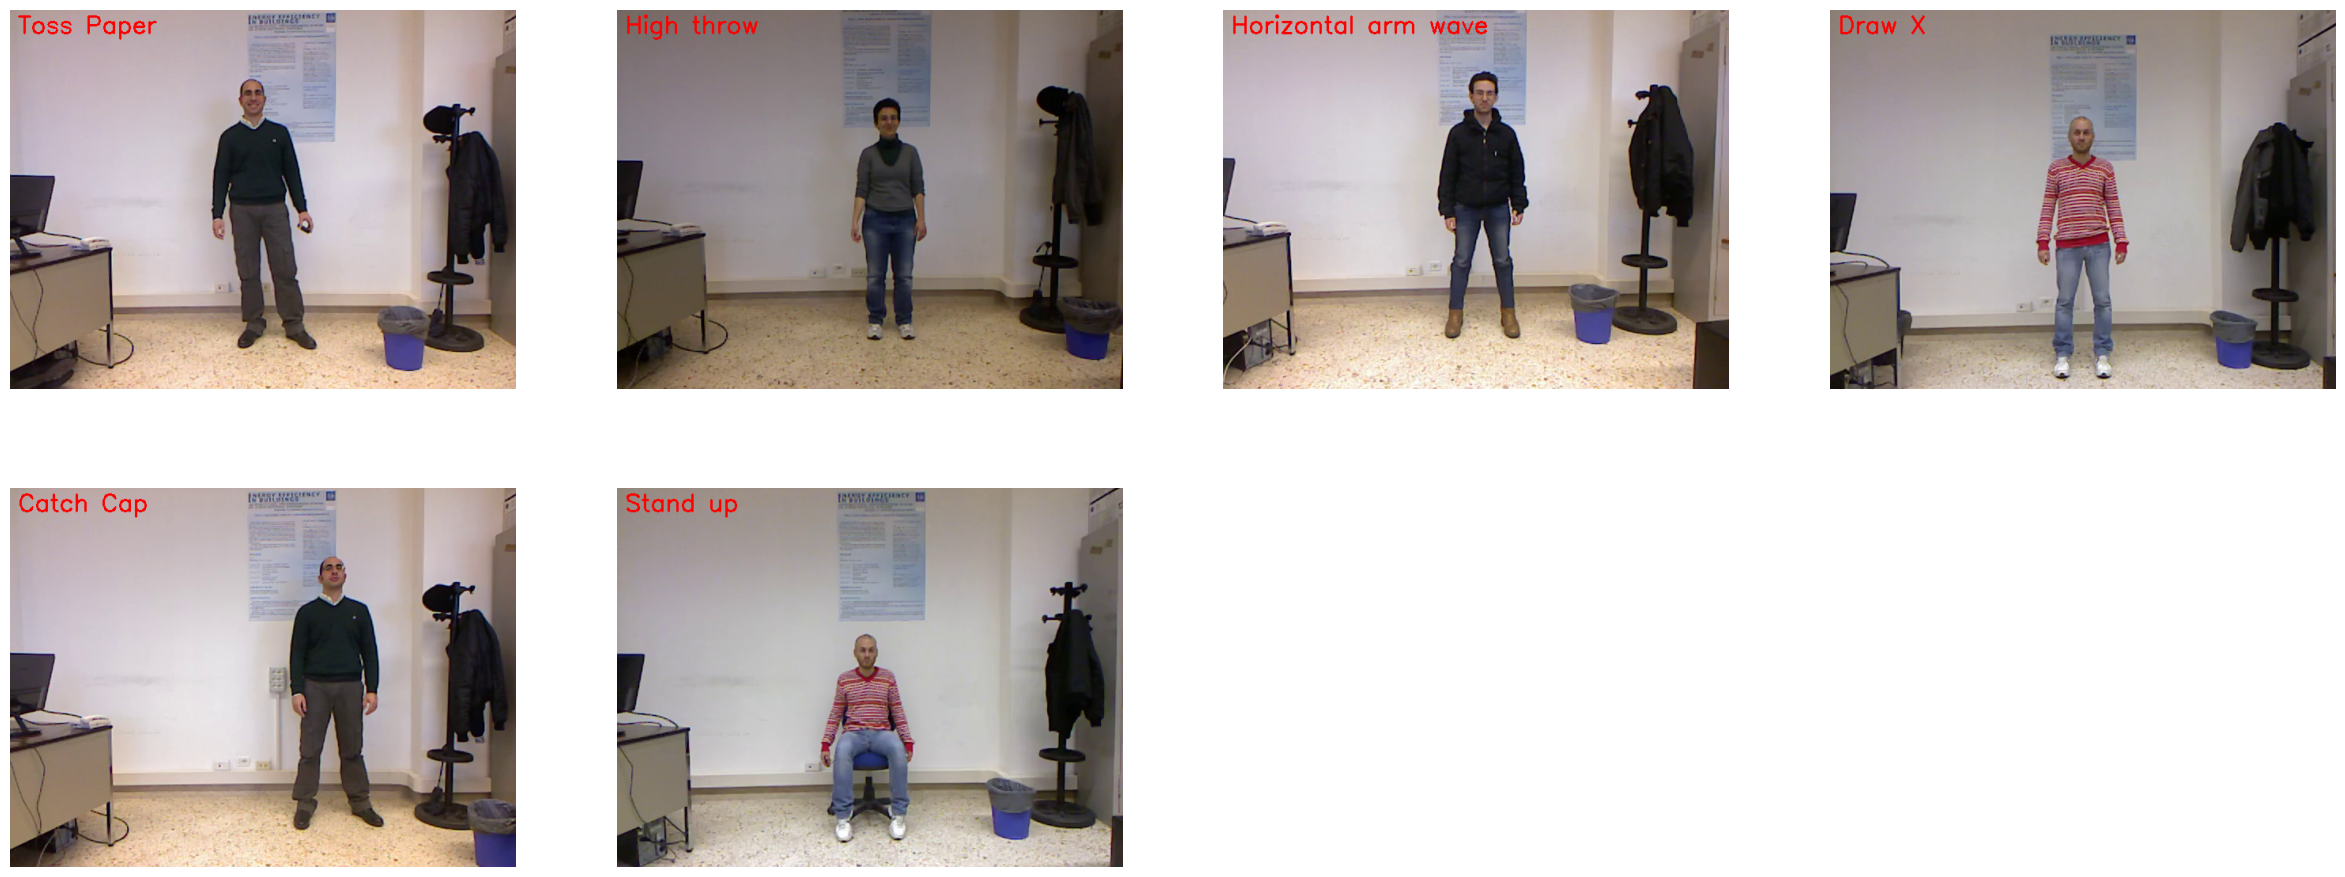

In [17]:
# Create a Matplotlib figure
plt.figure(figsize = (30, 30))
# Get Names of all classes in UCF50
all_classes_names = os.listdir('E:/KARD_video')
print(all_classes_names)
# Generate a random sample of images each time the cell runs
random_range = random.sample(range(len(all_classes_names)), 6)
# Iterating through all the random samples
for counter, random_index in enumerate(random_range, 1):
    # Getting Class Name using Random Index
    selected_class_Name = all_classes_names[random_index]
    # Getting a list of all the video files present in a Class Directory
    video_files_names_list = os.listdir(f'E:/KARD_video/{selected_class_Name}')
    # Randomly selecting a video file
    selected_video_file_name = random.choice(video_files_names_list)
    # Reading the Video File Using the Video Capture
    video_reader = cv2.VideoCapture(f'E:/KARD_video/{selected_class_Name}/{selected_video_file_name}')
    # Reading The First Frame of the Video File
    _, bgr_frame = video_reader.read()

    # Closing the VideoCapture object and releasing all resources.
    video_reader.release()
    # Converting the BGR Frame to RGB Frame
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

    # Adding The Class Name Text on top of the Video Frame.
    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
    # Assigning the Frame to a specific position of a subplot
    plt.subplot(5, 4, counter)
    plt.imshow(rgb_frame)
    plt.axis('off')

In [18]:
# for the creation of frames following required

image_height, image_width = 96, 96
max_images_per_class = 1000
dataset_directory = "E:/KARD_video"
classes_list = ['Take Umbrella', 'Sit down', 'Drink', 'Side Kick', 'Bend', 'Catch Cap', 'Toss Paper', 'Stand up', 'High arm wave', 'Horizontal arm wave', 'Walk', 'Hand Clap', 'Draw X', 'Forward Kick', 'Two hand wave', 'High throw', 'Phone Call', 'Draw Tick']

model_output_size = len(classes_list)

Frame Extraction

In [19]:
def frames_extraction(video_path):
    # Empty List declared to store video frames
    frames_list = []
    # Reading the Video File Using the VideoCapture
    video_reader = cv2.VideoCapture(video_path)

    # Iterating through Video Frames
    while True:
        # Reading a frame from the video file
        success, frame = video_reader.read()

        # If Video frame was not successfully read then break the loop
        if not success:
            break
        # Resize the Frame to fixed Dimensions
        resized_frame = cv2.resize(frame, (image_height, image_width))
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1

        normalized_frame = resized_frame / 255
        # Appending the normalized frame into the frames list
        frames_list.append(normalized_frame)
    # Closing the VideoCapture object and releasing all resources.
    video_reader.release()
    # returning the frames list
    return frames_list

Dataset Creation

In [20]:
def create_dataset():
    # Declaring Empty Lists to store the features and labels values.
    temp_features = []
    features = []
    labels = []

    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(classes_list):
        print(f'Extracting Data of Class: {class_name}')
        # Getting the list of video files present in the specific class name directory
        files_list = os.listdir(os.path.join(dataset_directory, class_name))
        # Iterating through all the files present in the files list
        for file_name in files_list:
            # Construct the complete video path
            video_file_path = os.path.join(dataset_directory, class_name, file_name)
            # Calling the frame_extraction method for every video file path
            frames = frames_extraction(video_file_path)

            # Appending the frames to a temporary list.
            temp_features.extend(frames)

        # Adding randomly selected frames to the features list
        features.extend(random.sample(temp_features, max_images_per_class))
        # Adding Fixed number of labels to the labels list

        labels.extend([class_index] * max_images_per_class)
        # Emptying the temp_features list so it can be reused to store all frames of the next class.
        temp_features.clear()
    # Converting the features and labels lists to numpy arrays
    features = np.asarray(features)

    labels = np.array(labels)
    return features, labels

In [21]:
features, labels = create_dataset()

Extracting Data of Class: Take Umbrella
Extracting Data of Class: Sit down
Extracting Data of Class: Drink
Extracting Data of Class: Side Kick
Extracting Data of Class: Bend
Extracting Data of Class: Catch Cap
Extracting Data of Class: Toss Paper
Extracting Data of Class: Stand up
Extracting Data of Class: High arm wave
Extracting Data of Class: Horizontal arm wave
Extracting Data of Class: Walk
Extracting Data of Class: Hand Clap
Extracting Data of Class: Draw X
Extracting Data of Class: Forward Kick
Extracting Data of Class: Two hand wave
Extracting Data of Class: High throw
Extracting Data of Class: Phone Call
Extracting Data of Class: Draw Tick


Data encoding

In [22]:
# Using Keras's to_categorical method to convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)

Spilt the data

In [23]:
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size = 0.2, shuffle = True, random_state = seed_constant)

In [24]:
# pip install tensorflow-gpu


In [25]:
import tensorflow as tf

# Check if TensorFlow is using GPU
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  1


Model Creation

In [26]:
import os, cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical  # Updated import
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten  # Corrected import
from tensorflow.keras.layers import Convolution2D, MaxPooling2D
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import os
from tensorflow.keras.regularizers import l1

from tensorflow.keras.layers import Activation, Conv2D, Dropout
from tensorflow.keras.layers import AveragePooling2D, BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import SeparableConv2D
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras import initializers
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import initializers


In [27]:
model = Sequential()
input_shape=(96,96,3)
##mini_exceptin

# img_input = Input(input_shape)

# Define the input layer
input_layer = Input(shape=input_shape)

input_layer.shape

x = SeparableConv2D(88, (3, 3), strides=(1, 1),padding='same',depthwise_initializer='he_normal',pointwise_initializer="he_normal",activation='relu', use_bias=False)(input_layer)
x = BatchNormalization()(x)
# x = Activation('relu')(x)
# x = SeparableConv2D(64, (3, 3), strides=(1, 1),depthwise_initializer='he_uniform',pointwise_initializer="he_uniform",padding='same',use_bias=False)(x)
# x = BatchNormalization()(x)
#x = Activation('relu')(x)
x

<KerasTensor: shape=(None, 96, 96, 88) dtype=float32 (created by layer 'batch_normalization')>

## Block 1

In [28]:
# module 1
residual = SeparableConv2D(32, (3, 3), strides=(1, 1), padding='same',depthwise_initializer='he_normal',pointwise_initializer="he_normal",activation='relu', use_bias=False)(x)
residual = BatchNormalization()(residual)

#residual=Activation('relu')(residual)


residual.shape

TensorShape([None, 96, 96, 32])

In [29]:
x1 = SeparableConv2D(32, (5, 5),strides=(1, 1), padding='same',depthwise_initializer='he_normal',pointwise_initializer="he_normal",activation='relu', use_bias=False)(x)
x1= BatchNormalization()(x1)
#x1 =Activation('relu')(x1)

x1.shape

TensorShape([None, 96, 96, 32])

In [30]:
x2 = SeparableConv2D(32, (1, 1),strides=(1, 1), padding='same',depthwise_initializer='he_normal',pointwise_initializer="he_normal", activation='relu',use_bias=False)(x)
x2= BatchNormalization()(x2)
#x2 =Activation('relu')(x2)

x2.shape

TensorShape([None, 96, 96, 32])

In [31]:
x11 = layers.add([x1, residual,x2])
x11 = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x11)
x11 = BatchNormalization()(x11)
x11 = Activation('relu')(x11)
x11.shape

TensorShape([None, 48, 48, 32])

##  Block 2

In [32]:
# module 2
residual2 = SeparableConv2D(64, (3, 3), strides=(1, 1), padding='same',depthwise_initializer='he_normal',pointwise_initializer="he_normal",activation='relu',use_bias=False)(x11)

residual2 = BatchNormalization()(residual2)
#residual2=Activation('relu')(residual2)

residual2.shape

TensorShape([None, 48, 48, 64])

In [33]:
x2 = SeparableConv2D(64, (5, 5),strides=(1, 1), padding='same',depthwise_initializer='he_normal',pointwise_initializer="he_normal", activation='relu',use_bias=False)(x11)
x2 = BatchNormalization()(x2)
#x2 = Activation('relu')(x2)

x2.shape

TensorShape([None, 48, 48, 64])

In [34]:
x3 = SeparableConv2D(64, (1, 1),strides=(1, 1), padding='same',depthwise_initializer='he_normal',pointwise_initializer="he_normal",activation='relu' ,use_bias=False)(x11)
x3 = BatchNormalization()(x3)
#x3 = Activation('relu')(x3)

x3.shape

TensorShape([None, 48, 48, 64])

In [35]:
x22 = layers.add([x2, residual2,x3])
#x22 = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x22)
x22 = BatchNormalization()(x22)
x22 = Activation('relu')(x22)
x22.shape

TensorShape([None, 48, 48, 64])

## Block 3

In [36]:
# module 3
residual3 = SeparableConv2D(128, (3, 3), strides=(1, 1), padding='same',depthwise_initializer='he_normal',pointwise_initializer="he_normal",activation='relu', use_bias=False)(x22)
residual3 = BatchNormalization()(residual3)
#residual3=Activation('relu')(residual3)

residual3.shape

TensorShape([None, 48, 48, 128])

In [37]:
x3 = SeparableConv2D(128, (5, 5),strides=(1, 1), padding='same',depthwise_initializer='he_normal',pointwise_initializer="he_normal",activation='relu', use_bias=False)(x22)
x3 = BatchNormalization()(x3)
#x3 = Activation('relu')(x3)

x3.shape

TensorShape([None, 48, 48, 128])

In [38]:
x4 = SeparableConv2D(128, (1, 1),strides=(1, 1), padding='same',depthwise_initializer='he_normal',pointwise_initializer="he_normal",activation='relu', use_bias=False)(x22)
x4 = BatchNormalization()(x4)
#x4 = Activation('relu')(x4)

x4.shape

TensorShape([None, 48, 48, 128])

In [39]:
x33 = layers.add([x3, residual3,x4])
#x33 = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x33)
x33 = BatchNormalization()(x33)
x33 = Activation('relu')(x33)
x33.shape

TensorShape([None, 48, 48, 128])

## Block 4

In [40]:
# # module 3
# residual3 = SeparableConv2D(256, (3, 3), strides=(1, 1), padding='same',depthwise_initializer='he_normal',pointwise_initializer="he_normal",activation='relu',kernel_regularizer='l1', use_bias=False)(x33)
# residual3 = BatchNormalization()(residual3)
# #residual3=Activation('relu')(residual3)

# residual3.shape

In [41]:
# x3 = SeparableConv2D(256, (5, 5),strides=(1, 1), padding='same',depthwise_initializer='he_normal',pointwise_initializer="he_normal",activation='relu',kernel_regularizer='l1', use_bias=False)(x33)
# x3 = BatchNormalization()(x3)
# #x3 = Activation('relu')(x3)

# x3.shape

In [42]:
# x4 = SeparableConv2D(256, (1, 1),strides=(1, 1), padding='same',depthwise_initializer='he_normal',pointwise_initializer="he_normal",activation='relu',kernel_regularizer='l1', use_bias=False)(x33)
# x4 = BatchNormalization()(x4)
# #x4 = Activation('relu')(x4)

# x4.shape

In [43]:
# x33 = layers.add([x3, residual3,x4])
# #x33 = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x33)
# x33 = BatchNormalization()(x33)
# x33 = Activation('relu')(x33)
# x33.shape


In [44]:
# x=Conv2D(6, (1, 1), padding='same')(x33)
# x = GlobalAveragePooling2D()(x)
# output = Activation('softmax', name='predictions')(x)

# x = GlobalAveragePooling2D()(x33)
# x=layers.Dropout(0.5)(x)
# output = Dense(6,activation='softmax')(x)

# x=Flatten()(x33)
x = GlobalAveragePooling2D()(x33)

x.shape

TensorShape([None, 128])

In [45]:
from tensorflow.keras.layers import LSTM

In [46]:
from tensorflow.keras.layers import Reshape

# Extract the number of frames from the input shape dynamically
num_frames = input_layer.shape[1]

# Add a reshape layer to convert the output of the preceding layer to have a third dimension
reshape_layer = Reshape(target_shape=(16, -1))(x)  # replace num_frames with the number of frames in your input data

reshape_layer.shape

TensorShape([None, 16, 8])

In [47]:
# Add the LSTM layer with the corrected input shape
# lstm_layer = LSTM(units=128, return_sequences=True)(x)  # set return_sequences=True if you want to stack LSTM layers

# lstm_layer.shape

In [48]:
# # Extract the number of frames from the input shape dynamically

# from tensorflow.keras.layers import Input, LSTM, Conv2D, MaxPooling2D, Flatten, Reshape, Concatenate, Dense, UpSampling2D

# # Reshape the output of the LSTM layer to have the same spatial dimensions as the output of the CNN layer
# reshape_layer = Reshape(target_shape=(1, 1, 128))(x)
# upsample_layer = UpSampling2D(size=(48, 48))(reshape_layer)

# upsample_layer.shape

In [49]:
# Add an LSTM layer with 64 units

lstm_layer = LSTM(units=128,return_sequences=True)(reshape_layer)

lstm_layer.shape

TensorShape([None, 16, 128])

In [50]:
# Add an LSTM layer with 64 units

lstm_layer = LSTM(units=64)(lstm_layer)

lstm_layer.shape

TensorShape([None, 64])

In [51]:
# Reshape the output of the LSTM layer to have the same spatial dimensions as the output of the CNN layer
# reshape_layer = Reshape(target_shape=(1, 1, 64))(lstm_layer)

# from tensorflow.keras.layers import Input, LSTM, Conv2D, MaxPooling2D, Flatten, Reshape, Concatenate, Dense, UpSampling2D

# # Reshape the output of the LSTM layer to have the same spatial dimensions as the output of the CNN layer
# reshape_layer = Reshape(target_shape=(1, 1, 64))(lstm_layer)
# upsample_layer = UpSampling2D(size=(48, 48))(reshape_layer)

# upsample_layer.shape

In [52]:
# Concatenate the upsampled output of the LSTM layer with the output of the CNN layer

# concat_layer = Concatenate()([upsample_layer, x4])

# concat_layer.shape

In [53]:
# x=Dense(64, activation='relu')(x)

x=Dropout(0.4)(lstm_layer)

x.shape

TensorShape([None, 64])

In [54]:
# Add a dense layer with 128 units and ReLU activation
# dense_layer1 = Dense(units=128, activation='relu')(concat_layer)

# dense_layer1.shape

In [55]:
# Add a final dense layer with softmax activation for classification
# output_layer = Dense(units=6, activation='softmax')(x)

# output_layer.shape

In [56]:
# x=Dense(512, activation='relu')(x)
# x=Dropout(0.5)(x)

output=Dense(18, activation='softmax')(x)

In [57]:
# Define the model with input and output layers

model = Model(input_layer, output)

In [58]:
# model = Model(img_input, output)

import keras
#adam = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, amsgrad=False)
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(),metrics=["accuracy"])

In [59]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 separable_conv2d (SeparableCon  (None, 96, 96, 88)  291         ['input_1[0][0]']                
 v2D)                                                                                             
                                                                                                  
 batch_normalization (BatchNorm  (None, 96, 96, 88)  352         ['separable_conv2d[0][0]']       
 alization)                                                                                       
                                                                                              

In [60]:
def lr_schedule(epoch):
  """
  Returns a custom learning rate that decreases as epochs progress.
  """
  learning_rate = 0.01
  if epoch > 10:
    learning_rate = 0.002
  if epoch > 30:
    learning_rate = 0.0002
  if epoch > 50:
    learning_rate = 0.0001

  tf.summary.scalar('learning rate', data=learning_rate, step=epoch)
  return learning_rate

In [61]:
from tensorflow import keras
lr_callback = keras.callbacks.LearningRateScheduler(lr_schedule)

In [62]:
# # Let's create a function that will construct our model
# def create_model():
#     # We will use a Sequential model for model construction
#     model = Sequential()
#     # Defining The Model Architecture
#     model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu', input_shape = (image_height, image_width, 3)))
#     model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
#     model.add(MaxPooling2D(pool_size = (2, 2)))
#     model.add(GlobalAveragePooling2D())
#     model.add(Dense(256, activation = 'relu'))
#     model.add(BatchNormalization())
#     model.add(Dense(model_output_size, activation = 'softmax'))
#     # Printing the models summary
#     model.summary()
#     return model
# # Calling the create_model method
# model = create_model()
# print("Model Created Successfully!")

In [63]:
# plot_model(model, to_file = 'model_structure_plot.png', show_shapes = True, show_layer_names = True)

In [64]:
# Adding Early Stopping Callback
# early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', restore_best_weights = True)
# Adding loss, optimizer and metrics values to the model.
# model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])
# Start Training
model_training_history = model.fit(x = features_train, y = labels_train, epochs = 1, batch_size = 32 , shuffle = True, validation_split = 0.2, callbacks = [lr_callback])

360/360 [==============================] - 32s 73ms/step - loss: 2.6046 - accuracy: 0.1311 - val_loss: 3.3233 - val_accuracy: 0.0729 - lr: 0.0100


In [65]:
model_evaluation_history = model.evaluate(features_test, labels_test)

113/113 [==============================] - 3s 17ms/step - loss: 3.3097 - accuracy: 0.0758


In [ ]:
#model.save('/content/drive/MyDrive/6_modified_data.h5')
#model.save('/content/drive/MyDrive/2_MSF_blocks(1,1,1)_modified_data1.h5')
#model.save('/content/drive/MyDrive/2_MSF_blocks(1,1,1)_original_data1.h5')
#model.save('/content/drive/MyDrive/1_MSF_blocks(1,1,1)_modified_data1.h5')
#model.save('/content/drive/MyDrive/1_MSF_blocks(1,1,1)_original_data1.h5')
#model.save('/content/drive/MyDrive/5_MSF_blocks(1,3,5)_modified_data1.h5')
#model.save('/content/drive/MyDrive/5_MSF_blocks(1,3,5)_original_data1.h5')
#model.save('/content/drive/MyDrive/6_MSF_blocks(1,3,5)_modified_data1.h5')
#model.save('/content/drive/MyDrive/6_MSF_blocks(1,3,5)_original_data1.h5')

#model.save('/content/drive/MyDrive/3_MSF_blocks(1,3,5)_modified_data1.h5')
model.save('/content/drive/MyDrive/(Maxpooling)kard.h5')
#model.save('/content/drive/MyDrive/4_MSF_blocks(1,3,5)_original_data1.h5')
#model.save('/content/drive/MyDrive/4_MSF_blocks(1,3,5)_modified_data1.h5')

In [ ]:
from tensorflow.keras.models import load_model
#new_model = load_model('/content/drive/MyDrive/6_modified_data.h5')
new_model = load_model('/content/drive/MyDrive/(Maxpooling)kard.h5')
#new_model = load_model('/content/drive/MyDrive/4_MSF_blocks(1,3,5)_original_data1.h5')
#new_model = load_model('/content/drive/MyDrive/2_MSF_blocks(1,1,1)_modified_data1.h5')
#new_model = load_model('/content/drive/MyDrive/2_MSF_blocks(1,1,1)_original_data1.h5')
#new_model = load_model('/content/drive/MyDrive/1_MSF_blocks(1,1,1)_modified_data1.h5')
#new_model = load_model('/content/drive/MyDrive/1_MSF_blocks(1,1,1)_original_data1.h5')
#new_model = load_model('/content/drive/MyDrive/5_MSF_blocks(1,3,5)_modified_data1.h5')
#new_model = load_model('/content/drive/MyDrive/5_MSF_blocks(1,3,5)_original_data1.h5')
#new_model = load_model('/content/drive/MyDrive/6_MSF_blocks(1,3,5)_modified_data1.h5')
#new_model = load_model('/content/drive/MyDrive/6_MSF_blocks(1,3,5)_original_data1.h5')

#new_model = load_model('/content/drive/MyDrive/3_MSF_blocks(1,3,5)_modified_data1.h5')
#new_model = load_model('/content/drive/MyDrive/4_MSF_blocks(1,3,5)_modified_data1.h5')

In [66]:
import tensorflow as tf
from tensorflow.python.profiler.model_analyzer import profile
from tensorflow.python.profiler.option_builder import ProfileOptionBuilder
print('TensorFlow:', tf.__version__)



forward_pass = tf.function(
    model.call,
    input_signature=[tf.TensorSpec(shape=(1,) + model.input_shape[1:])])

graph_info = profile(forward_pass.get_concrete_function().graph,
                        options=ProfileOptionBuilder.float_operation())

# The //2 is necessary since `profile` counts multiply and accumulate
# as two flops, here we report the total number of multiply accumulate ops
flops = graph_info.total_float_ops // 2
print('Flops: {:,}'.format(flops))

TensorFlow: 2.10.1
Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`
Flops: 187,924,662


In [67]:
# Creating a useful name for our model, incase you're saving multiple models (OPTIONAL)
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history
model_name = f'Model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'
# Saving your Model
model.save(model_name)


In [68]:

def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    '''
    This function will plot the metrics passed to it in a graph.
    Args:
        model_training_history: A history object containing a record of training and validation
                                loss values and metrics values at successive epochs
        metric_name_1:          The name of the first metric that needs to be plotted in the graph.
        metric_name_2:          The name of the second metric that needs to be plotted in the graph.
        plot_name:              The title of the graph.
    '''

    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]

    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))

    # Plot the Graph.
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    # Add title to the plot.
    plt.title(str(plot_name))

    # Add legend to the plot.
    plt.legend()

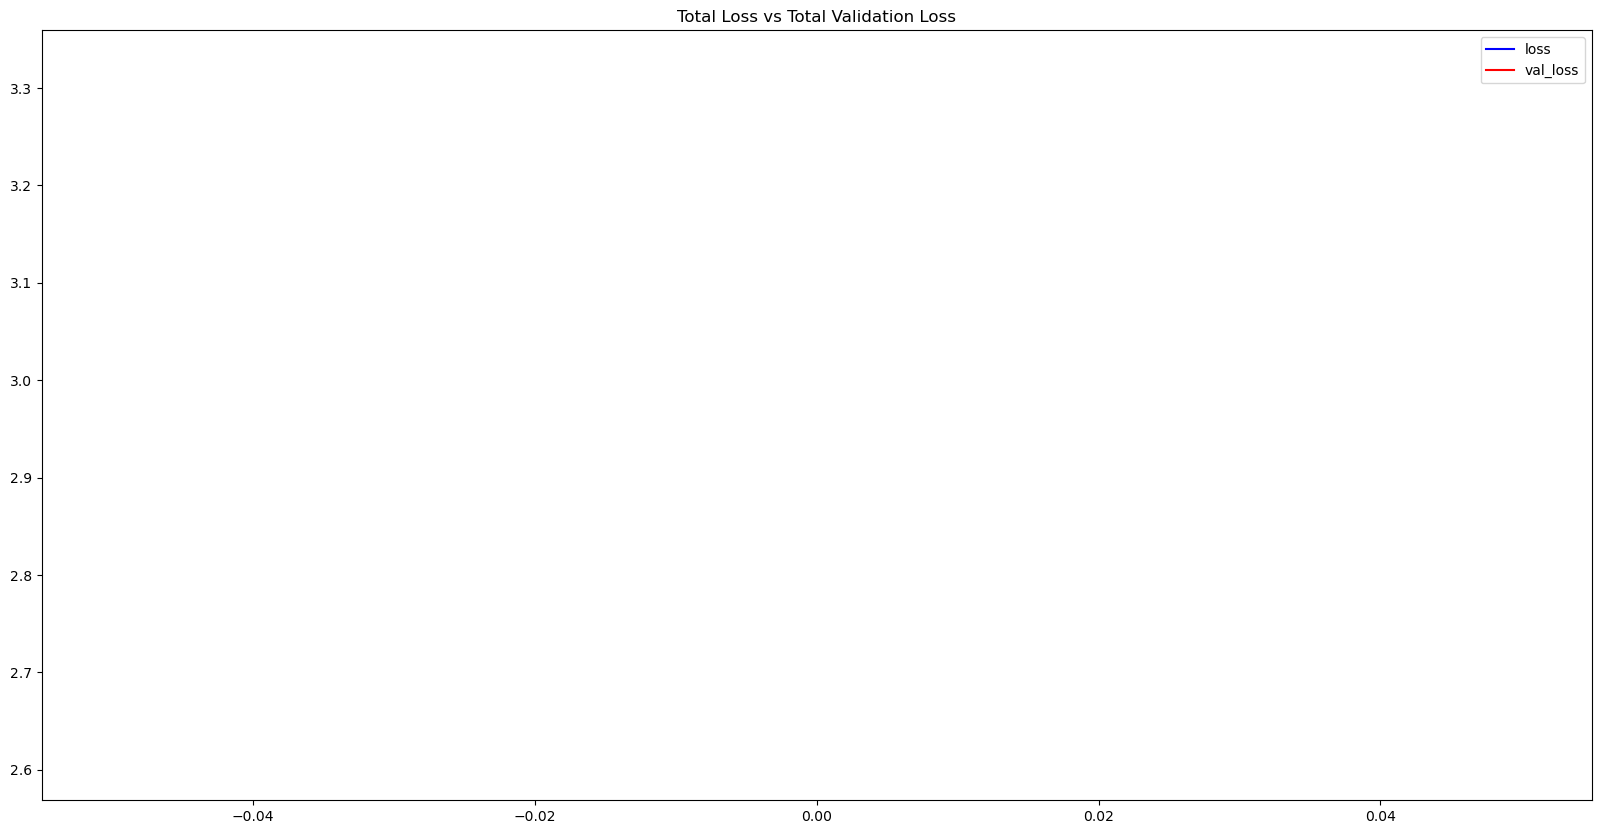

In [69]:

# Visualize the training and validation loss metrices.
plot_metric(model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

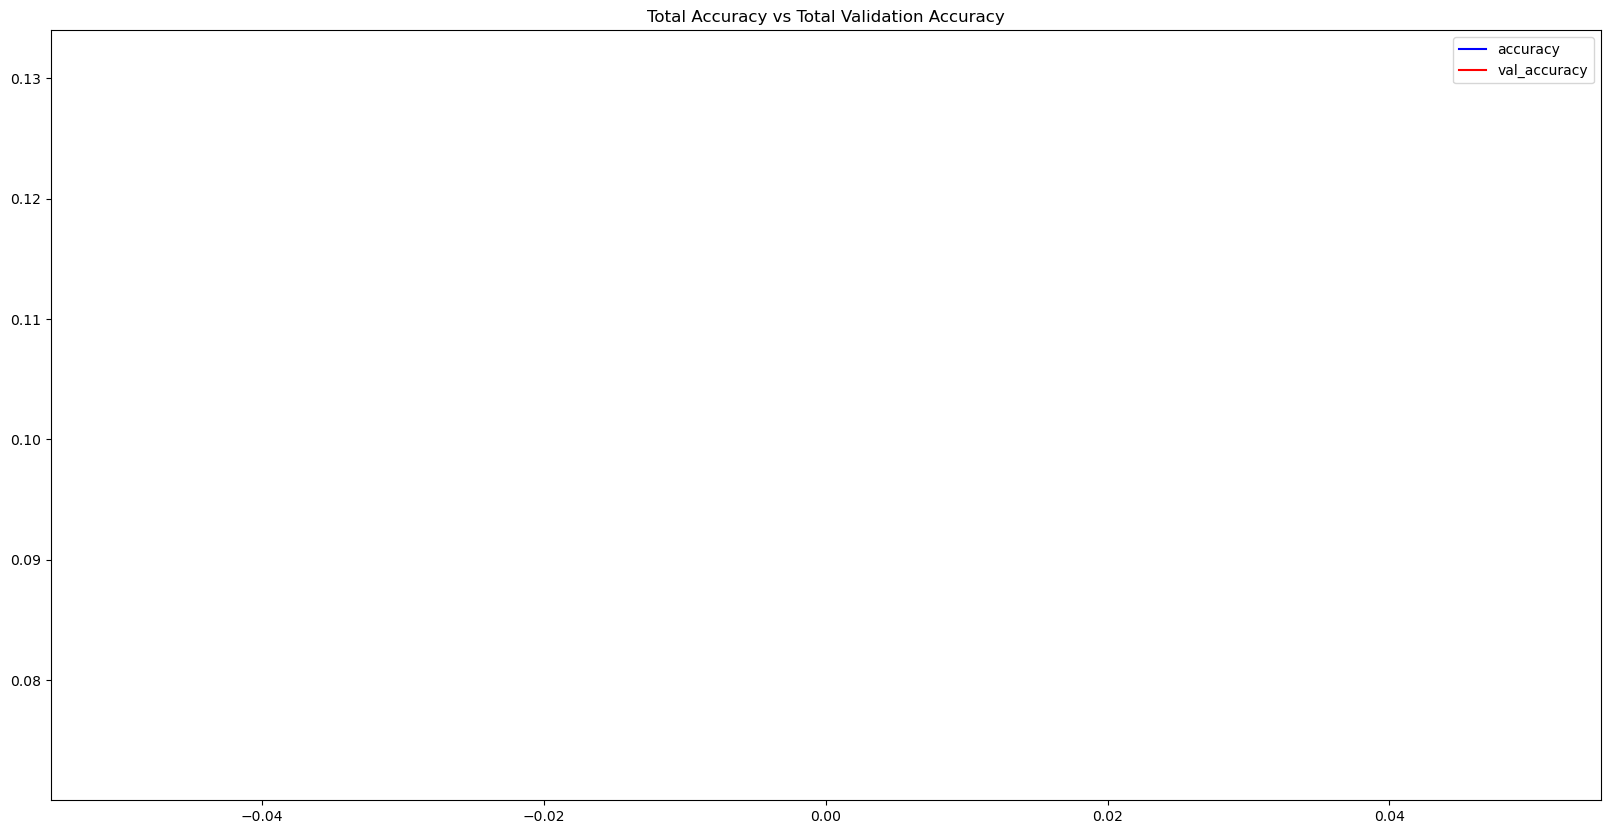

In [70]:

# Visualize the training and validation accuracy metrices.
plot_metric(model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')



In [71]:
def predict_on_live_video(video_file_path, output_file_path, window_size):
    # Initialize a Deque Object with a fixed size which will be used to implement moving/rolling average functionality.
    predicted_labels_probabilities_deque = deque(maxlen = window_size)
    # Reading the Video File using the VideoCapture Object
    video_reader = cv2.VideoCapture(video_file_path)
    # Getting the width and height of the video
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))
    # Writing the Overlayed Video Files Using the VideoWriter Object
    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('M', 'P', '4', 'V'), 24, (original_video_width, original_video_height))
    while True:
        # Reading The Frame
        status, frame = video_reader.read()
        if not status:
            break
        # Resize the Frame to fixed Dimensions
        resized_frame = cv2.resize(frame, (image_height, image_width))
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255
        # Passing the Image Normalized Frame to the model and receiving Predicted Probabilities.
        predicted_labels_probabilities = model.predict(np.expand_dims(normalized_frame, axis = 0))[0]
        # Appending predicted label probabilities to the deque object
        predicted_labels_probabilities_deque.append(predicted_labels_probabilities)
        # Assuring that the Deque is completely filled before starting the averaging process
        if len(predicted_labels_probabilities_deque) == window_size:
            # Converting Predicted Labels Probabilities Deque into Numpy array
            predicted_labels_probabilities_np = np.array(predicted_labels_probabilities_deque)
            # Calculating Average of Predicted Labels Probabilities Column Wise
            predicted_labels_probabilities_averaged = predicted_labels_probabilities_np.mean(axis = 0)
            # Converting the predicted probabilities into labels by returning the index of the maximum value.
            predicted_label = np.argmax(predicted_labels_probabilities_averaged)
            # Accessing The Class Name using predicted label.
            predicted_class_name = classes_list[predicted_label]
            # Overlaying Class Name Text Ontop of the Frame
            cv2.putText(frame, predicted_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
        # Writing The Frame
        video_writer.write(frame)
        # cv2.imshow('Predicted Frames', frame)
        # key_pressed = cv2.waitKey(10)
        # if key_pressed == ord('q'):
        #     break
    # cv2.destroyAllWindows()
    # Closing the VideoCapture and VideoWriter objects and releasing all resources held by them.
    video_reader.release()
    video_writer.release()


In [ ]:

# Make the Output directory if it does not exist
test_videos_directory = 'test_videos'
os.makedirs(test_videos_directory, exist_ok = True)

# Download a YouTube Video.
video_title = '/content/pexels-rodnae-productions-7045239 (1).mp4'

# Get the YouTube Video's path we just downloaded.
input_video_file_path = f'/content/pexels-rodnae-productions-7045239 (1).mp4'

In [ ]:
# Setting the Window Size which will be used by the Rolling Average Process
window_size = 25
# Constructing The Output YouTube Video Path
output_video_file_path = f'/content/42_18_2.avi-Output-WSize {window_size}.mp4'
# Calling the predict_on_live_video method to start the Prediction and Rolling Average Process
predict_on_live_video(input_video_file_path, output_video_file_path, window_size)
# Play Video File in the Notebook
VideoFileClip(output_video_file_path).ipython_display(width = 700)


In [72]:
score1, acc1 = model.evaluate(features_train,labels_train, batch_size=32,verbose=0)
print('Train score1:', score1,'Train accuracy1:', acc1)

Train score1: 3.3362066745758057 Train accuracy1: 0.07354166358709335


In [73]:
score2, acc2 = model.evaluate(features_test,labels_test, batch_size=32,verbose=0)
print('Test score1:', score2,'Test accuracy1:', acc2)

Test score1: 3.309662103652954 Test accuracy1: 0.07583333551883698


In [74]:
import numpy as np

y_pred1 = model.predict(features_test)
y_pred=np.argmax(y_pred1,axis=1)
#y_true = tf.math.argmax(testY, axis=1)
y_true = np.argmax(labels_test, axis=-1) #np_utils.categorical_probas_to_classes(y_test)

# Compute a confusion matrix and a normalised confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
cm = confusion_matrix(y_true, y_pred)
cm_normalised = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

113/113 [==============================] - 3s 15ms/step


In [75]:
# These can also be used to produce heatmaps using Matplotlib or Seaborn.
print(cm)
print(cm_normalised)

[[  0   0   0   0   0   1   0   0   0   0   0   0   0  53  83   0   0  66]
 [  0   0  27   0   2   1   1   0   0   1   0   0   0  32 115  11   0  18]
 [  0   0  39   0   0   0   0   0   0   0   0   0   0  11  93  49   0   0]
 [  0   0  16   0   0   0   0   0   0   0   0   0   0   4 171  15   0   2]
 [  0   0  35   0   3   0   0   0   0   0   0   0   0  24  93  10   0  21]
 [  0   0   0   0   0   1   0   0   0   0   0   0   0  36 122   7   0  46]
 [  0   0   9   0   0   1   0   0   0   3   0   0   0  16 139  20   0   2]
 [  0   0  16   0   6   0   3   3   0   0   0   0   0  50  81  18   0  22]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0 137  38   0  17]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0 163  55   0   8]
 [  1   0   5   0   9  24   0   0   0   0   0   0   0  38  52   4   0  62]
 [  0   0  23   0   0   0   0   0   0   0   0   0   0  30 154  14   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0  12 160   6   0  13]
 [  0   0  18   0   0   0

In [76]:
classes = classes_list
print(classes)

['Take Umbrella', 'Sit down', 'Drink', 'Side Kick', 'Bend', 'Catch Cap', 'Toss Paper', 'Stand up', 'High arm wave', 'Horizontal arm wave', 'Walk', 'Hand Clap', 'Draw X', 'Forward Kick', 'Two hand wave', 'High throw', 'Phone Call', 'Draw Tick']


In [77]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Reds):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = cm.round(2)
        #print("Normalized confusion matrix")
    else:
        cm=cm
        #print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

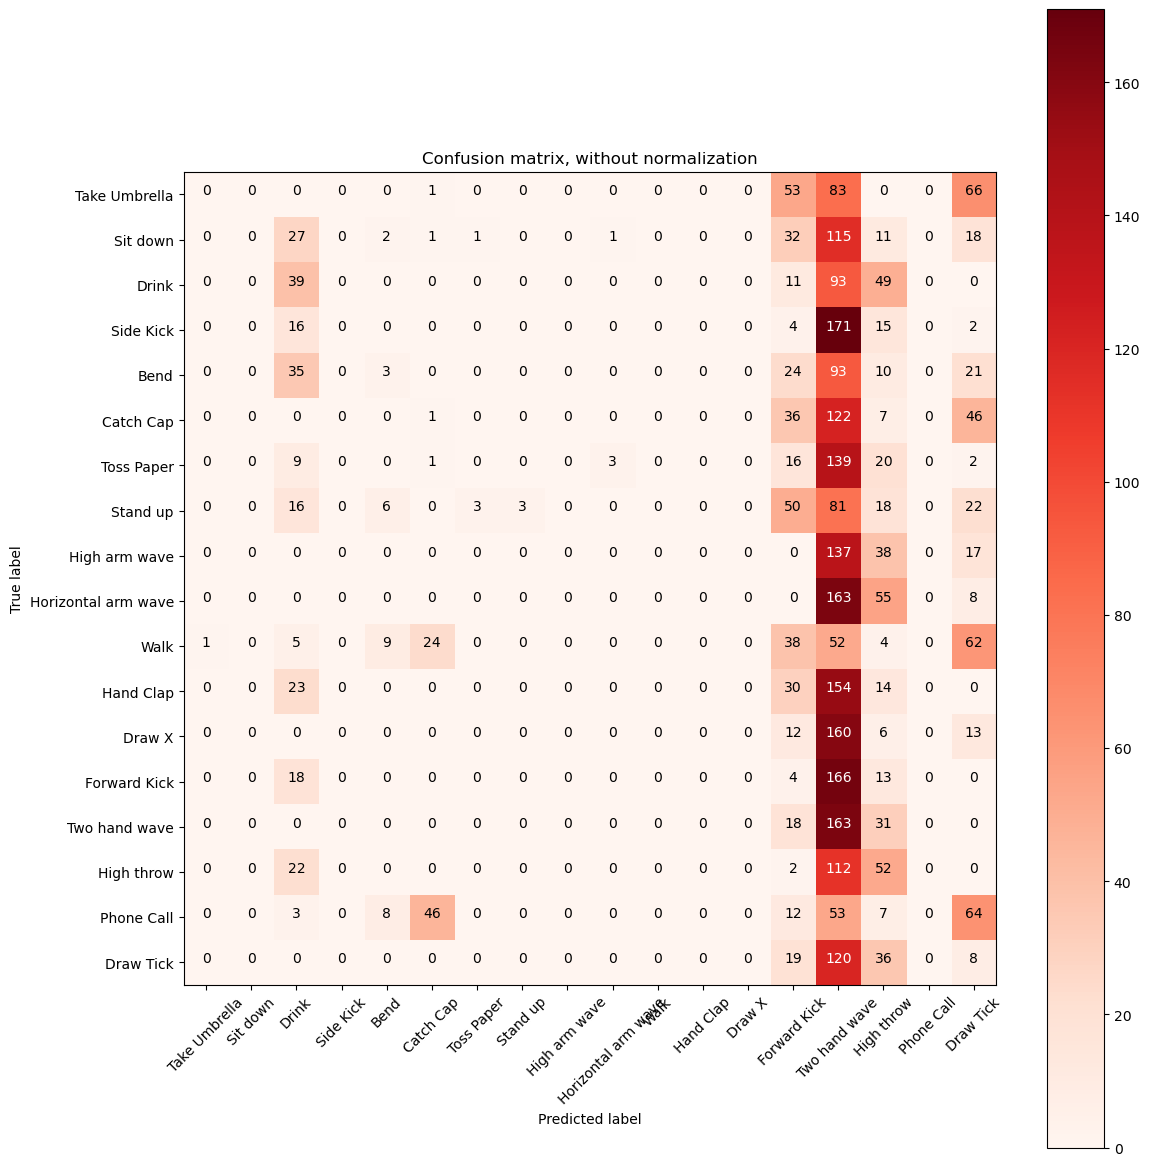

In [78]:
np.set_printoptions(precision=2)

fig1 = plt.figure(figsize=(12,12))
plot_confusion_matrix(cm, classes=classes_list , title='Confusion matrix, without normalization')
plt.show()

In [79]:
from sklearn.metrics import classification_report

In [80]:
print(classification_report(y_true, y_pred,digits=4))

              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       203
           1     0.0000    0.0000    0.0000       208
           2     0.1831    0.2031    0.1926       192
           3     0.0000    0.0000    0.0000       208
           4     0.1071    0.0161    0.0280       186
           5     0.0135    0.0047    0.0070       212
           6     0.0000    0.0000    0.0000       190
           7     1.0000    0.0151    0.0297       199
           8     0.0000    0.0000    0.0000       192
           9     0.0000    0.0000    0.0000       226
          10     0.0000    0.0000    0.0000       195
          11     0.0000    0.0000    0.0000       221
          12     0.0000    0.0000    0.0000       191
          13     0.0111    0.0199    0.0142       201
          14     0.0749    0.7689    0.1365       212
          15     0.1347    0.2766    0.1812       188
          16     0.0000    0.0000    0.0000       193
          17     0.0229    

c:\Users\hp\.conda\envs\prediction\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\hp\.conda\envs\prediction\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\hp\.conda\envs\prediction\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
